In [10]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from skspatial.objects import Plane, Points, LineSegment, Vector, Line
# from SE3 import se3, SE3
from lienp.SE3 import SE3
from lienp.SO3 import SO3

import pickle

cam_id = 1
with open(f"../scripts/calib_data_camera{cam_id}.pkl", "rb") as fs:
    calib_data = pickle.load(fs)

markers_mean = Points(np.mean(calib_data['markers'], axis=0))
plane = Plane.best_fit(markers_mean)
point = plane.project_point(markers_mean[0,:])
markers_p = Points([plane.project_point(marker) for marker in markers_mean])

n_cols = 5
n_rows = 7
dim = 0.142
board_corners = []
for i in np.arange(n_rows):
    for j in np.arange(n_cols):
        corner = [j * dim, i * dim, -0.008]
        board_corners.append(corner)
board_corners = Points(board_corners)

T_board_offset = SE3(param=np.array([0, dim * 6, 0, 0, 0, np.pi/2]))

p0, p1, p2, p3 = markers_p
vec1 = Vector(p0 - p1)
seg1 = LineSegment(p0, p1)

vec2 = Vector(p3 - p2)
seg2 = LineSegment(p3, p2)

board_origin = seg1.intersect_line_segment(seg2)
print(f'board_origin: {board_origin}')
board_x = Vector(p0 - board_origin) # fix the board x to be the long side
board_x = board_x / board_x.norm()
board_z = plane.normal / plane.normal.norm()
board_y = board_z.cross(board_x)

R_board = np.array([board_x, board_y, board_z])
c_board = np.array(board_origin)
T_board = SE3(R=R_board, c=board_origin)

board_corners_corr = (T_board.inv @ T_board_offset.M @ np.vstack([board_corners.T, np.ones(35)]))[0:-1, :].T
print(board_corners_corr.shape)

board_origin: [0.43152087 2.93451092 0.04151239]
(35, 3)


In [11]:
def draw_ref_frame(ax, T: SE3, scale=1, alpha=.5):
    c = T.c
    R = T.R
    l1 = Line(c, R[0,:])
    l2 = Line(c, R[1,:])
    l3 = Line(c, R[2,:])
    ax1 = LineSegment(c, l1.to_point(scale))
    ax2 = LineSegment(c, l2.to_point(scale))
    ax3 = LineSegment(c, l3.to_point(scale))
    ax1.plot_3d(ax, color='r', alpha=alpha)
    ax2.plot_3d(ax, color='g', alpha=alpha)
    ax3.plot_3d(ax, color='b', alpha=alpha)
    ax.set_aspect("equal")

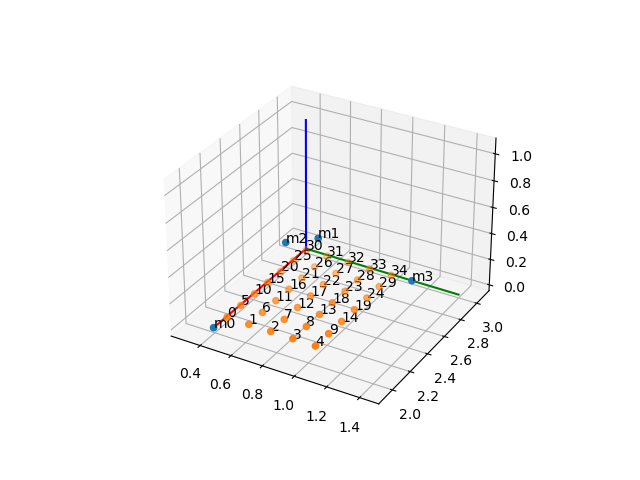

In [12]:
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')

markers_p.plot_3d(ax, alpha=1)

# ax.set_aspect("equal")
for i, txt in enumerate(np.arange(markers_mean.shape[0])):
    ax.text(markers_p[i,0], markers_p[i,1], markers_p[i,2], f"m{i}", None)

Points(board_corners_corr).plot_3d(ax)
for i, txt in enumerate(np.arange(board_corners.shape[0])):
    ax.text(board_corners_corr[i,0], board_corners_corr[i,1], board_corners_corr[i,2], f"{i}", None)

Line(board_origin, board_x).plot_3d(ax, color='r')
Line(board_origin, board_y).plot_3d(ax, color='g')
Line(board_origin, board_z).plot_3d(ax, color='b')

In [13]:
import os, yaml, cv2
info_dir = os.path.abspath( os.path.join(os.path.dirname(''), os.pardir)) + "/camera_info/"
with open(f'{info_dir}/camera{cam_id}.yaml', 'r') as fs:
    cam_info = yaml.safe_load(fs)
K = np.array(cam_info["camera_matrix"]["data"])
cam_dist = np.array(cam_info["distortion_coefficients"]["data"])
K_opt, dist_valid_roi = cv2.getOptimalNewCameraMatrix(K.reshape(3,3), cam_dist, (1600,1200), 1, (1600, 1200))


(35, 2)


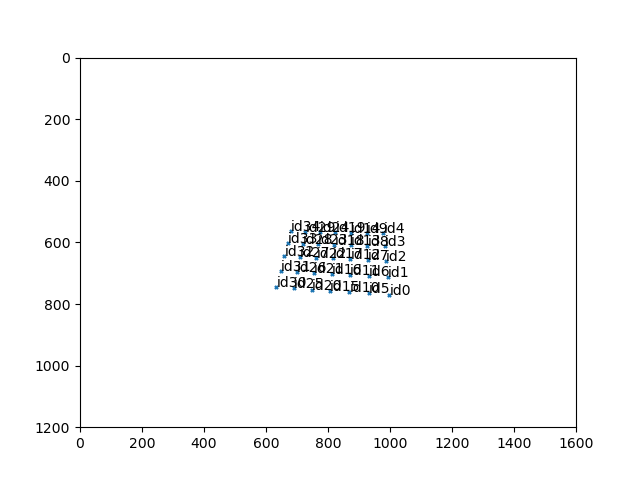

In [14]:
charuco_corners = np.array(calib_data['corners'][0])
print(charuco_corners.shape)
charuco_corners_rect = cv2.undistortPoints(np.expand_dims(charuco_corners, axis=0), K.reshape(3,3), cam_dist, P=K_opt)
charuco_corners_rect = np.squeeze(charuco_corners_rect)

fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.set_xlim(0,1600)
ax.set_ylim(1200,0)
# ax.scatter(charuco_corners[:,0], charuco_corners[:,1], s=1)
ax.scatter(charuco_corners_rect[:,0], charuco_corners_rect[:,1], s=5, marker='x')
for i, txt in enumerate(calib_data['ids'][0]):
    ax.text(charuco_corners_rect[i,0], charuco_corners_rect[i,1], f"id{i}", None)

In [15]:
import sys
module_path = os.path.abspath(os.path.join('../scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lpnp import solve_lpnp
board_corners_corr.shape[0]
T_op, res = solve_lpnp(image_points=charuco_corners_rect, object_points=board_corners_corr, K_opt=K_opt)
T_op, res

(array([[ 0.61282264,  0.09388044, -0.78462403,  0.78848899],
        [-0.07475903,  0.99535223,  0.06070433, -2.43555373],
        [ 0.78667623,  0.02145674,  0.6169928 , -0.82258898],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-6.26754748e-14],
        [ 8.53404418e-12],
        [-2.38657387e-11],
        [-2.80674134e-12],
        [-1.61073858e-11],
        [-5.35550673e-12]]))

In [16]:
cam_mocap_pose = calib_data['cam_mocap_pose'][0]
q = cam_mocap_pose[3:7]
R_mocap = SO3.from_quat(q)
T_cam_mocap = SE3(R=SO3.from_quat(cam_mocap_pose[3:]).T, c=cam_mocap_pose[0:3])
T_calib = T_op @ T_cam_mocap.inv
print(T_calib)
import json
with open(f'../camera_info/camera{cam_id}_mocap_calib.json', 'w') as fs:
    data = {"R": T_calib.R.tolist(), "c": T_calib.c.tolist()}
    json.dump(data, fs)

array([[ 0.99422342, -0.0423808 ,  0.09860857, -0.01227533],
       [ 0.03965143,  0.99877869,  0.02947681,  0.02374415],
       [-0.09973738, -0.02539656,  0.99468963,  0.02887406],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])


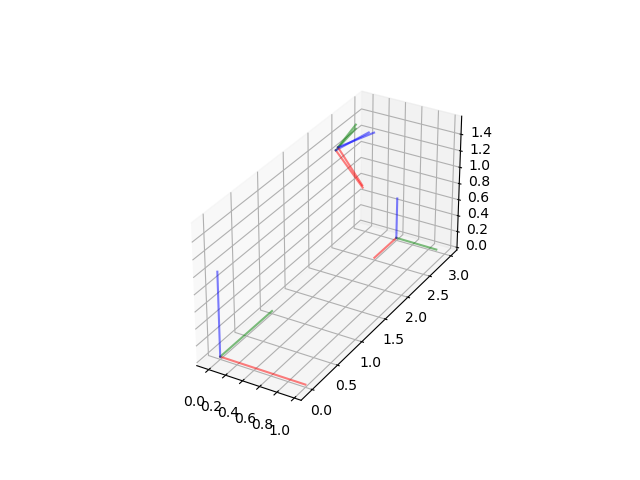

In [18]:

fig_ = plt.figure()
ax = fig_.add_subplot(111, projection='3d')
draw_ref_frame(ax, SE3(np.zeros(6)))
draw_ref_frame(ax, T_op, scale=0.5)
draw_ref_frame(ax, T_board, scale=0.5)
draw_ref_frame(ax, T_cam_mocap, scale=0.5)
